# Simulación numérica | Máquina de Atwood

[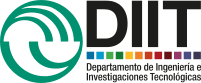](https://ingenieria.unlam.edu.ar/)  
2022 [Víctor A. Bettachini](mailto:vbettachini@unlam.edu.ar)  
[by-nc-sa_80x15.png](https://creativecommons.org/licenses/by-sa/4.0/deed.es_ES) 

---

## Enunciado
En el siguiente problema resolverá numericamente cada ecuación de Euler-Lagrange que corresponda a cada coordenada generalizada.
Graficando tales soluciones, en el rango de tiempos y con las condiciones iniciales indicadas, estará simulando la dinámica de tales sistemas.  
La aceleracion gravitatoria tiene por magnitud \\(|\vec{g}| = 9.81\,\mathrm{m s^{-2}}\\).
 
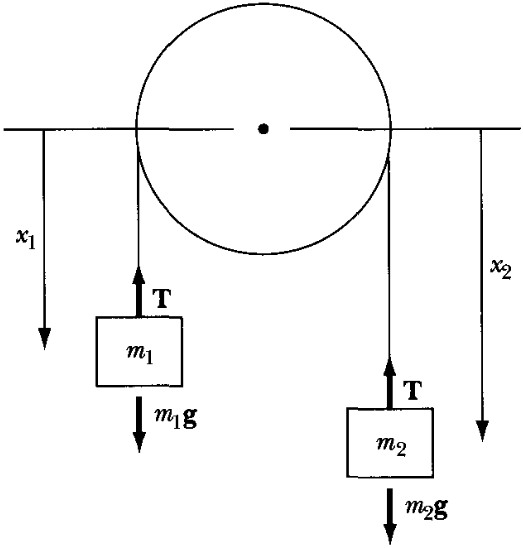

### Parámetros de simulación
Rango de tiempo \\(t = 0 - 10\,\mathrm{s}\\).  
Parámetros físicos y condiciones iniciales:  
\\(\ell_\mathrm{cuerda} > 150\,\mathrm{m}\\),
\\(R_{\mathrm{polea}} = 0.5\,\mathrm{m}\\),  
\\(m_1 = 8\,\mathrm{kg}\\),
\\(m_2 = 1\,\mathrm{kg}\\),
\\(M_\mathrm{polea} = 4\,\mathrm{kg}\\),  
\\(x(t=0) = 25\,\mathrm{m}\\),
\\(\dot{x}(t=0) = -10\,\mathrm{m\,s^{-2}}\\).

## Resolución simbólica

In [1]:
import sympy as sym # módulo de cálculo simbólico
from sympy.physics import mechanics as mech
mech.init_vprinting() # notación con punto para la velocidad y punto punto para la aceleración

### Modelo físico del sistema

In [2]:
# Sistema de coordenadas
e = mech.ReferenceFrame('e') # sistema de coordenadas
t = sym.symbols('t') # tiempo
M, R, m1, m2, g, l = sym.symbols('M, R, m_1, m_2, g, \ell', positive=True) # Parámetros físicos del sistema

#### Coordenadas generalizas y ligaduras

In [3]:
x1, x2, theta = mech.dynamicsymbols(r'x_1, x_2, \theta') # Coordenadas generalizadas 
# función de ligadura 1: longitud constante de la cuerda
f1 = sym.Eq(x1+ x2 + sym.pi* R - l, 0 )
# función de ligadura 2: cuerda gira solidaria a la polea (no desliza)
f2 = sym.Eq(x1.diff(t)/R - theta.diff(t)/ sym.pi, 0)

In [4]:
x2_f1 = sym.solveset(f1, x2).args[0]
x2_f1 = sym.Eq(x2, sym.solveset(f1.lhs, x2).args[0])

#### Posiciones en función de coordenas generalizadas

In [5]:
m1_r = -R * e.x + x1* (-e.y) # versor y para arriba
m2_r = R * e.x + x2_f1.rhs* (-e.y) # resto longitud hilo x1 y media vuelta polea
m1_r, m2_r

### Energías cinéticas de traslación

In [6]:
def energíaCinéticaPartícula(masa, posición, marcoDeReferencia):
    """
    A partir de la masa y posición de una partícula puntual en un marco de referencia devuelve su energía cinética.
    
    Parámetros
    ----------
    masa: (sympy.core.symbol.Symbol)
        De un partícula
    posición: (sympy.physics.vector.vector.Vector)
        del centro de masa de la partícula
    marcoDeReferencia: (sympy.physics.vector.frame.ReferenceFrame)
        En el que se expresa la posición
    
    Retorna
    -------
    Energía cinética(sympy.core.mul.Mul)
        T = (m/2) \dot{\vec{r}} \cdot\dot{\vec{r}}
    """
    velocidad = posición.diff(t, marcoDeReferencia)
    unMedio = sym.Rational(1,2) # Rational: fracción de enteros, alternativamente podría haberse usado 0.5 
    return unMedio* masa* velocidad.dot(velocidad)

In [7]:
T_m1 = energíaCinéticaPartícula(m1, m1_r, e)
T_m2 = energíaCinéticaPartícula(m2, m2_r, e)

### Energía cinética de rotación

In [8]:
def energíaCinéticaRotación(momentoDeInercia, velocidadAngular):
    """
    Calcula la energía cinética de un cuerpo extenso (no puntual) que rota en torno a un eje.
    
    Parámetros
    ----------
    momentoDeInercia : Igualdad Sympy (sympy.Equality)
        Expresada en referencia al eje de rotación para la velocidadAngular.
    velocidadAngular : Igualdad Sympy (sympy.Equality)
        Velocidad de rotación en torno a un eje.
        
    Retorna
    -------
    Igualdad Sympy (sympy.Equality)
        Energía cinética de rotación (I/2)* omega**2
    """
    unMedio = sym.Rational(1,2) # Rational: fracción de enteros, alternativamente podría haberse usado 0.5 
    return unMedio* momentoDeInercia* velocidadAngular**2

In [9]:
unMedio = sym.Rational(1,2) # Rational: fracción de enteros, alternativamente podría haberse usado 0.5 
I_cilindro = sym.Eq(sym.Symbol('I'), unMedio* M* R**2) # momento de inercia de rotación en torno a su eje de simetría longitudinal

velocidadAngular_cilindro = theta.diff(t)

T_rotaciónPolea = energíaCinéticaRotación(I_cilindro.rhs, velocidadAngular_cilindro )
sym.Eq( sym.Symbol('T_\mathrm{rotación}'), T_rotaciónPolea)

Que aprovechando la función de ligadura para la polea y la cuerda.

In [10]:
thetaPunto_f2 = sym.solveset(f2.lhs, velocidadAngular_cilindro ).args[0]
sym.Eq(velocidadAngular_cilindro, thetaPunto_f2 )

In [11]:
T_rotaciónPolea_x1 = T_rotaciónPolea.subs(velocidadAngular_cilindro, thetaPunto_f2)
sym.Eq( sym.Symbol('T_\mathrm{rotación}'), T_rotaciónPolea_x1)

### Energía potencial

In [12]:
# Energía potencial
g_vector = g* (-e.y) # aceleración gravitatoria en -y versor
V_m1 = m1* (-g_vector).dot(m1_r)
V_m2 = m2* (-g_vector).dot(m2_r)
V = (V_m1 + V_m2).simplify()
sym.Eq(sym.Symbol('V'), V )

### Ecuación de Euler-Lagrange

In [13]:
def eulerLagrange(T, V, coordenadaGeneralizada):
    '''    
    Esta función devuelve la ecuación de Euler-Lagrange para una coordenada generalizada a partir de las energías del sistema.
    
    Parámetros
    ----------
    T : Igualdad Sympy (sympy.Equality)
        En su lado derecho explicita la energía cinética del sistema en función de coordenadas y velocidades generalizadas y el tiempo.
    V : Igualdad Sympy (sympy.Equality)
        En su lado derecho explicita la energía potencial del sistema en función de coordenadas y velocidades generalizadas y el tiempo.
    coordenadaGeneralizada: Símbolo Sympy (sympy.Symbol)
        Para la que quiere obtenerse la ecuación de Euler-Lagrange
        
    Retorna
    -------
    Igualdad Sympy (sympy.Equality)
        Ecuación de Euler-Lagrange para la coordenadaGeneralizada
    '''
    lagrangiano = (T - V).expand()
    return sym.Eq(
        lagrangiano.diff(coordenadaGeneralizada) 
        - lagrangiano.diff(coordenadaGeneralizada.diff(t)).diff(t)
        , 0
    ).simplify()

In [14]:
x1_EL = eulerLagrange(T_m1+ T_m2+ T_rotaciónPolea_x1, V, x1)
x1_EL

Esta es una ecuación diferencial lineal de segundo orden homogena.
De aquí se puede despejar $\ddot{x}$

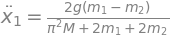

In [15]:
x_pp = sym.Eq(x1.diff(t,2),
       list( sym.solveset(x1_EL, x1.diff(t,2) ) )[0]  # solveset devuelve un set, que convertimos a lista
      )
x_pp # aceleración = x punto punto [m s-2]

## Resolución analítica de la ecuación de Euler-Lagrange

Resolver analíticamente esta ecuación es sencillo.
Basta con integrar dos veces en el tiempo esta $\ddot{x}$ para obtener $x(t)$ 

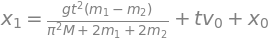

In [16]:
x_0, v_0 = sym.symbols('x_0 v_0')
sym.Eq(x1, unMedio* x_pp.rhs* t**2+ v_0* t + x_0)

En este caso de un sistema mecánico muy simple hacer una resolución analítica de una ecuación de Euler-Lagrange, que es una ecuación diferencial ordinaria (ODE en inglés) resultó trivial.

Pero hacer esto en sistemas mecánicos complejos puede ser engorroso o inclusive imposible.
Por esa razón exploraremos la alternativa que es la **resolución numérica** .

## Resolución numérica

### Integración numérica de una ecuación diferencial de primer orden
> Referencia  
["Métodos numéricos para ecuaciones diferenciales" Wikipedia, La enciclopedia libre.](https://es.wikipedia.org/wiki/M%C3%A9todos_num%C3%A9ricos_para_ecuaciones_diferenciales_ordinarias#M%C3%A9todo_de_Euler)

No es difícil de probar que posiciones en tiempos sucesivos $x(t_i)$, $x(t_{i+1})$ están relacionadas por la velocidad en algún tiempo intermedio
$$
x(t_{i+1}) 
= x(t_i) + \frac{\partial x}{\partial t}\bigg|_{t_i \leq t \leq t_{i+1}} (t_{i+1} - t_i)
= x(t_i) + \dot{x}|_{t_i \leq t \leq t_{i+1}} (t_{i+1} - t_i) .
$$

El método de Euler para la integración numérica se basa en que si $(t_{i+1} - t_i) \ll 1$ el error que se comete de usar la velocidad en $t_i$ es pequeño
$$
x(t_{i+1}) \simeq x(t_i) + \dot{x}(t_i) (t_{i+1} - t_i).
$$
Luego es cuestión de calcular $\dot{x}(t_{i+1})$ y se puede avanzar a $x(t_{i+2})$.
Y así sucesivamente habiendo partido de unas condiciones iniciales
- $x(t_0)$
- $\dot{x}(t_0)$

### Vector de estado en $t_i$

Los métodos numéricos más eficientes trabajan sobre una ecuación diferencial de primer orden.
Para utilizarlos se reduce la ecuación de la dinámica, una **ecuación diferencial ordinaria de 2.o orden**, a un **sistema de dos ecuaciones de 1.er orden**.

La implementación computacional de estos métodos trabajan calculando sucesivos**vectores de estado** 
$$
\vec{y}_i 
= \begin{vmatrix}
y_{0,i}\\
y_{1,i}
\end{vmatrix}
= \begin{vmatrix}
x_i\\
\dot{x}_i
\end{vmatrix},
$$
donde el primer elemento de cada vector, $y_{0,i}$, es la posición $x_i$ en un tiempo particular $t_i$ y el segundo, $y_{0,i}$, la velocidad.

Siguiendo el método de Euler partiendo del vector de estado en $t_i$, $\vec{y}_{i}$, se calcula el vector para $t_{i+1}$ según
$$
\vec{y}_{i+1} = \vec{y}_i + \dot{\vec{y}}_n(t_i) \Delta t_i,
$$
donde $\Delta t_i = t_{i+1} - t_i$, e $\dot{\vec{y}}_n(t_i)$ es la derivada respecto al tiempo del vector de estado,
$$
\dot{\vec{y}}_i = 
\begin{vmatrix}
\dot{x}_i \\
\ddot{x}_i
\end{vmatrix}.
$$

Es segundo elemento de $\dot{\vec{y}}_n(t_i)$, $\dot{y}_{1,i}$, se corresponde con $\ddot{x}_i$, es decir la **aceleración generalizada**.
Todas las aceleraciones generalizadas que se requieran para simular la dinámica de un sistema se obtienen de despejarlas del sistema de ecuaciones obtenidas con Euler-Lagrange.

En la máquina de Atwood simple la relación que se da entre los elementos del vector de estado, $\vec{y}$, y su derivada respecto al tiempo, $\dot{\vec{y}}$, se resume en lo siguiente:
$$
\left\{
\begin{array}{l}
y_{0,i} = x_i\\
y_{1,i} = \dot{y}_{0,i} =  \dot{x}_i\\
\dot{y}_{1,i} = \ddot{y}_{0,i} = \ddot{x}_i = g \frac{(m1 - m_2)}{m_1 + m_2}\\
\end{array}
\right. ,
$$

En el caso de este sistema $\ddot{x}_i \equiv \mathrm{constaste}$, pero en un caso general
$$
\ddot{x}_i = \ddot{x}_i(t_i, x_j, \dot{x}_j),
$$
es decir puede ser función de $t_i, x_j$ y/o $\dot{x}_j$.
**Importante:** notesé que aquí $x_j$ y $\dot{x}_j$ tienen $j$ como subíndice, i.e. que una aceleración generalizada $\ddot{x}_i$ puede depender no solo de la propia coordinada y velocidad generalizada, las de subíndice $i$, sino también de otras que se usaron para describir el sistema, i.e. las de subíndices $j \neq i$.

### Método de Runge-Kutta
> Referencias:
> - ["Método de Runge-Kutta" Wikipedia, La enciclopedia libre.](https://es.wikipedia.org/wiki/M%C3%A9todo_de_Runge-Kutta)
> - [ Metodos-Numericos/Clase 21 - EDOs - Runge Kutta.ipynb ](https://github.com/jorgenorena/Metodos-Numericos/blob/main/Clase%2021%20-%20EDOs%20-%20Runge%20Kutta.ipynb)

El método que utilizaremos para integrar el conjunto de ecuaciones diferenciales (ODE inglés) que generamos a partir de las ecuaciones de Euler-Lagrange es uno de Runge-Kutta, siendo el de Euler un caso particular entre ellos.
Estos métodos calculan $y_{i+1}$ aprovechando más de un vector estado anterior.

#### Implementación de Runge-Kutta en la biblioteca SciPy
> Referencias:
>- https://docs.scipy.org/doc/scipy/tutorial/integrate.html#ordinary-differential-equations-solve-ivp
>- https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
> - https://pundit.pratt.duke.edu/wiki/Python:Ordinary_Differential_Equations/Examples
> - http://sam-dolan.staff.shef.ac.uk/mas212/notebooks/ODE_Example.html
> - https://ipython-books.github.io/123-simulating-an-ordinary-differential-equation-with-scipy/

Se utilizará un método de Runge-Kutta de orden 5(4), i.e. donde el error se controla asumiendo la exactitud de un método de cuarto orden, pero los $\Delta t$ se toman usando una fórmula exacta de quinto orden.
Es un **método de paso variable** que en cada $y_i$ estima el error que tendrá el próximo, $y_{i+1}$, dado un determinado $\Delta t_i$.
El método intenta maximizar cada $\Delta t_i$, para que finalmente se requieran menos $i$, pero respetando siempre un límite para el error.

### Valores numéricos

Necesitamos establecer la magnitud de $\ddot{x}$, esto es cuantos $\mathrm{\frac{m}{s^2}}$, en función de los parámetros físicos del sistema.

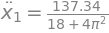

In [17]:
# parámetros_físicos
g_magnitud = 9.81 # [m s-2]
m_1_magnitud = 8 # [kg]
m_2_magnitud = 1 # [kg]
M_magnitud = 4 # [kg]
magnitudes = {
    g : g_magnitud,
    m1 : m_1_magnitud,
    m2 : m_2_magnitud,
    M : M_magnitud,
}
x1_pp_magnitudes = x_pp.subs(magnitudes)
x1_pp_magnitudes # [m s-2]

In [18]:
type(x1_pp_magnitudes)

sympy.core.relational.Equality

Lo anterior es una expresión `sympy`.
Para hacer cálculos con ella necesito poner su magnitud en una expresión que pueda interpretarse fuera de este módulo.
Para esto se usa el comando `lambdify` que retorna la función en un formato compatible con el módulo de Python indicado.
Por defecto este módulo es el `numpy` que es la que usaremos a continuación.
Obligatoriamente hay que indicar al menos una variable de la que depende la función.
En este caso se indicó $t$ aunque realmente no figura en $\ddot{x}$. 

In [19]:
x1_pp_numpy = sym.lambdify(t, x1_pp_magnitudes.rhs)
x1_pp_numpy = x1_pp_numpy(9999) # en este caso el valor de t no afecta nada, pero debe indicarse uno
x1_pp_numpy # [m s-2]

In [20]:
type(x1_pp_numpy)

float

### Condiciones iniciales
Ahora defino condiciones iniciales del sistema y el rango de tiempo a analizar 

In [21]:
# biblioteca de cálculo numérico general
import numpy as np

In [22]:
y_inicial = [25, -10] # [unidades SI] posicion, velocidad, en el mismo orden que en vector estado
t_rango = np.linspace(0, 10, 100) # tiempos inicial,final y cuantos tiempos intermedios equiespaciados

La resolución se realiza entre los extremos de este intervalo `t_rango`, pero se utilizarán los valores intermedios para que la integración 
guarde el resultado de todos los vectores de estado de los más próximos a los tiempos en `t_rango`.

In [23]:
# biblioteca de cálculo científico: eficientes herramientas de cálculo numérico
# Importo la función solve_ivp: resolver un sistema de ODEs con condiciones iniciales
from scipy.integrate import solve_ivp

In [24]:
# defino una función con el sistema de derivadas
# t : no se usa en este sistema pero lo dejamos para uso posterior
# y : lista de estado con [y_0, y_1]
# constantes : lista de constates, en este caso tendrá g(m1-m2)/(m1+m2)
# dx_dt : lista de derivadas
def y_punto(t, y):
    velocidad = y[1] # 2.o elemento del vector de estado
    aceleracion = x1_pp_numpy
    dy_dt = [velocidad, aceleracion]
    return dy_dt

In [25]:
# Integración de a pasos en el tiempo
y_ode2 = solve_ivp(y_punto, (t_rango[0], t_rango[-1] ), y_inicial, t_eval = t_rango)

In [26]:
y_ode2

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.1010101 ,  0.2020202 ,  0.3030303 ,  0.4040404 ,
        0.50505051,  0.60606061,  0.70707071,  0.80808081,  0.90909091,
        1.01010101,  1.11111111,  1.21212121,  1.31313131,  1.41414141,
        1.51515152,  1.61616162,  1.71717172,  1.81818182,  1.91919192,
        2.02020202,  2.12121212,  2.22222222,  2.32323232,  2.42424242,
        2.52525253,  2.62626263,  2.72727273,  2.82828283,  2.92929293,
        3.03030303,  3.13131313,  3.23232323,  3.33333333,  3.43434343,
        3.53535354,  3.63636364,  3.73737374,  3.83838384,  3.93939394,
        4.04040404,  4.14141414,  4.24242424,  4.34343434,  4.44444444,
        4.54545455,  4.64646465,  4.74747475,  4.84848485,  4.94949495,
        5.05050505,  5.15151515,  5.25252525,  5.35353535,  5.45454545,
        5.55555556,  5.6565656

Aquí se ve que `y_ode2.t` son los tiempos en que se hicieron los puntos intermedios según $\Delta t_i$ dentro de `t_rango`. 

Los resultados de la integracíon están en `y_ode2.y`. Las $x(t)$ en `y_ode2.y[0]` y las $\dot{x}(t)$ en `y_ode2.y[1]`.

**obs** La primera línea indica `message: 'The solver successfully reached the end of the integration interval.'` Esto quiere decir que la integración resultó exitosa (resolvió el problema). En problemas más complejos esto puede fallar e indicará que así sucede.

## Graficación

Para producir una representación visual de los resultas de utilizará la biblioteca _Matplotlib_.
De ellas se usa el subconjunto de funciones _pyplot_.
Y de estas utilizaremos el estilo de dibujo que semeja al del popular sitio de análisis estadístico de temas políticos y deporte estadounidense [FiveThirtyEight](https://fivethirtyeight.com/).

In [27]:
# biblioteca de graficación
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Se genera una figura doble con dos conjuntos de ejes dispuestos en una fila y dos columnas.
A la izquierda `ax[0,0]` y a derecha `ax[0,1]`.
En cada eje se trazan (plot) lineas que interpolan los pares de puntos de tiempo en las abcisas, `y_ode.t`, y las respectivas ordenadas `y_ode2.y[0]` para la coordenada generalizada y `y_ode2.y[1]` para su velocidad.

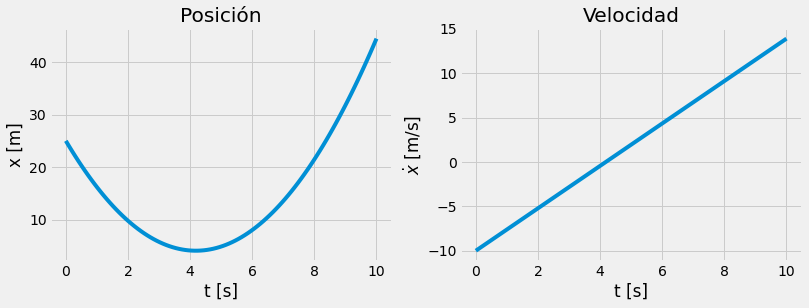

In [28]:
fig, ax = plt.subplots(nrows= 1, ncols= 2, squeeze=False, figsize=(12, 4)) # dos figuras en la misma fila
ax[0,0].set(xlabel='t [s]', ylabel='x [m]', title='Posición')
ax[0,0].plot(y_ode2.t, y_ode2.y[0]) # fila 0 columna 0
ax[0,1].set(xlabel='t [s]', ylabel='$\dot{x}$ [m/s]', title='Velocidad')
ax[0,1].plot(y_ode2.t, y_ode2.y[1]) # fila 0 columna 1

### Error del método numérico
Comparemos con la solución analítica

Defino funciones que calculan la posición y velocidad a partir de la $\ddot{x}$ despejada de la ecuación de Euler-Lagrange. 

In [29]:
def x_mruv(a, v_0, x_0, t):
    return 0.5* a* t**2 + v_0* t + x_0

def v_mruv(a, v_0, t):
    return a* t + v_0

Y grafico la solución numérica, la analítica y su diferencia para evaluar el error de la primera.

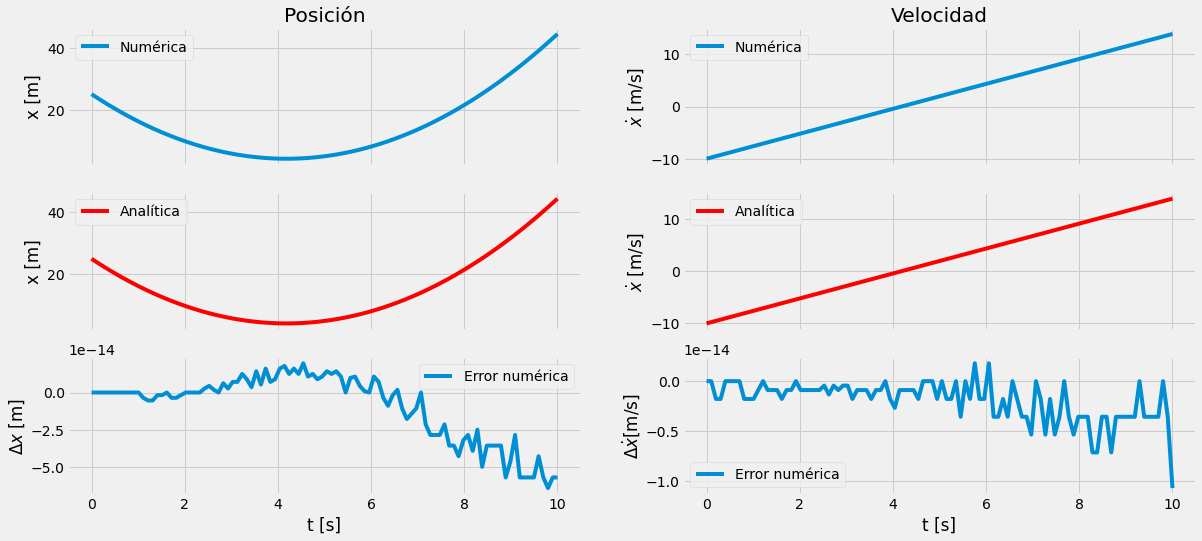

In [30]:
fig, ax = plt.subplots(nrows= 3, ncols= 2, figsize=(18, 8), sharex= True) # dos figuras en la misma fila

ax[0,0].set(ylabel='x [m]', title='Posición')
ax[0,0].plot(y_ode2.t, y_ode2.y[0], label='Numérica') # fila 0 columna 0
ax[0,0].legend()

ax[1,0].set(ylabel='x [m]')
ax[1,0].plot(y_ode2.t, x_mruv(x1_pp_numpy, y_inicial[1], y_inicial[0], y_ode2.t), 'r', label='Analítica') # fila 0 columna 0
ax[1,0].legend()

ax[2,0].set(xlabel='t [s]', ylabel='$\Delta x$ [m]')
ax[2,0].plot(y_ode2.t, y_ode2.y[0] - x_mruv(x1_pp_numpy, y_inicial[1], y_inicial[0], y_ode2.t), label='Error numérica') # fila 0 columna 0
ax[2,0].legend()

ax[0,1].set(ylabel='$\dot{x}$ [m/s]', title='Velocidad')
ax[0,1].plot(y_ode2.t, y_ode2.y[1], label='Numérica') # fila 0 columna 1
ax[0,1].legend()

ax[1,1].set(ylabel='$\dot{x}$ [m/s]')
ax[1,1].plot(y_ode2.t, v_mruv(x1_pp_numpy, y_inicial[1], y_ode2.t), 'r', label='Analítica') # fila 0 columna 0
ax[1,1].legend()

ax[2,1].set(xlabel='t [s]', ylabel='$\Delta \dot{x}$[m/s]')
ax[2,1].plot(y_ode2.t, y_ode2.y[1] - v_mruv(x1_pp_numpy, y_inicial[1], y_ode2.t), label='Error numérica') # fila 0 columna 0
ax[2,1].legend()

El algorítmo de integración mantiene el error de $x$ dentro de un tolerancia. 
La cota de este puede ajustarse para que se modifique en cada $\Delta t_i$ la predicción de $\dot{x}$
Por eso esta última va _acumulando_ error, pero su magnitud es despreciable. 